**Introduction to Artificial Neural Networks with Keras**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

LIBRARIES

In [77]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [78]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from scipy.stats import reciprocal


In [79]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [80]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

In [81]:
tf.__version__

'2.19.0'

In [82]:
keras.__version__

'3.10.0'

In [83]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../../."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [84]:
iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [85]:
y_pred

array([1])

Saving figure perceptron_iris_plot


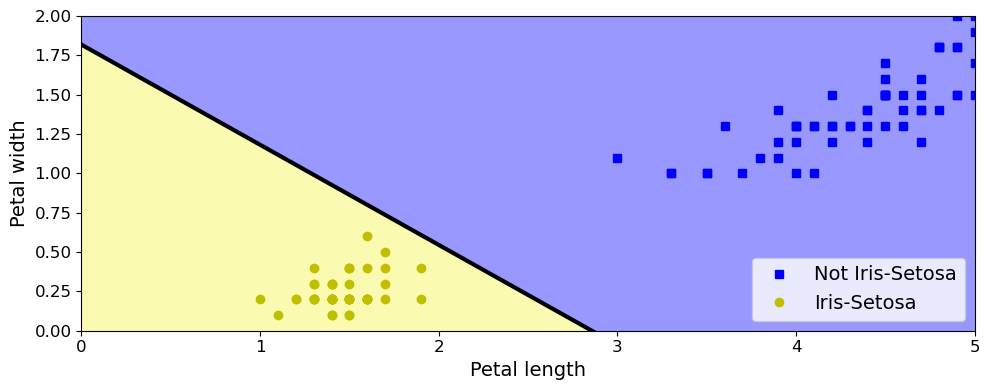

In [86]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [87]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


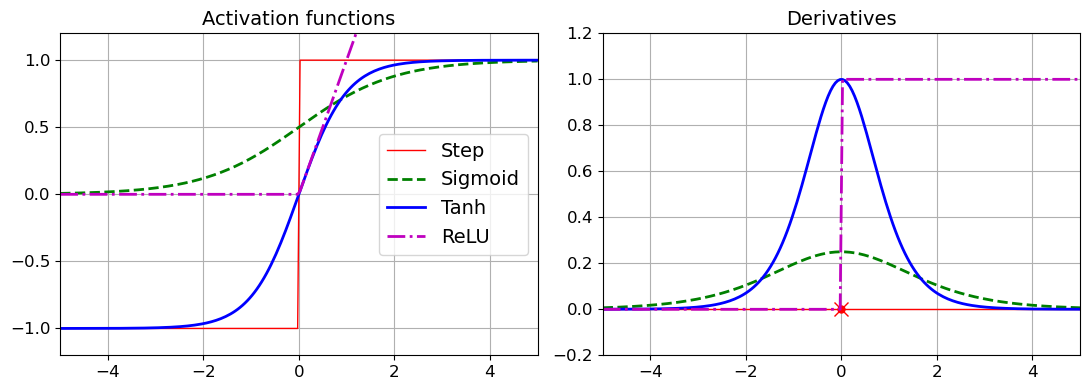

In [88]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [89]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

In [90]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

In [91]:
import tensorflow as tf
from tensorflow import keras

In [92]:
tf.__version__

'2.19.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [93]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [94]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [95]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [96]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

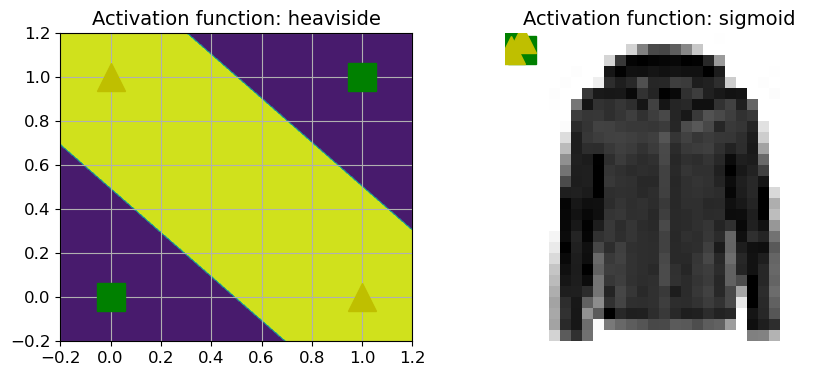

In [97]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [98]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [99]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [100]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [101]:
X_valid.shape

(5000, 28, 28)

In [102]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


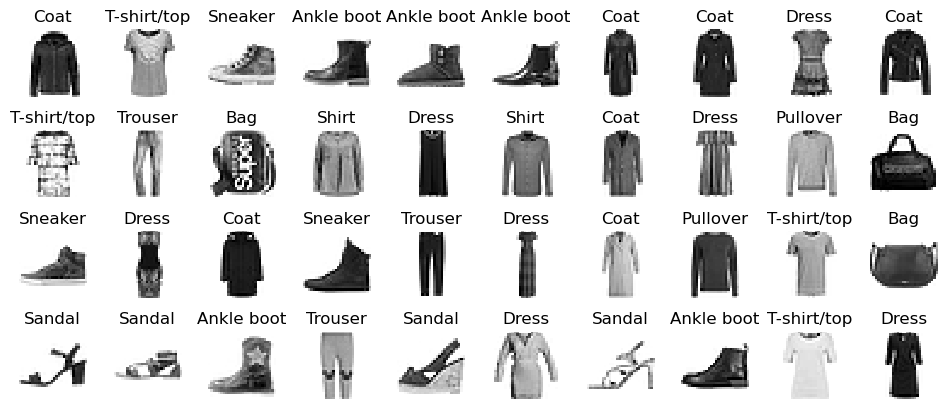

In [103]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [104]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

c:\Users\chern\anaconda3\envs\ML_template\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [107]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [108]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [110]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [111]:
model.get_layer(hidden1.name) is hidden1

True

In [112]:
weights, biases = hidden1.get_weights()

In [113]:
weights

array([[ 0.00177851, -0.0446614 , -0.03210388, ..., -0.03676843,
        -0.05217884,  0.05502762],
       [-0.01477601, -0.00311375, -0.06626433, ...,  0.06733696,
         0.01233888, -0.02449628],
       [-0.06319939,  0.06484047,  0.02733572, ..., -0.01108766,
        -0.00641429, -0.0074596 ],
       ...,
       [ 0.06772563,  0.01301708, -0.03117215, ...,  0.07384603,
         0.06291892,  0.00369334],
       [ 0.05183689, -0.00644507,  0.05153349, ..., -0.03916188,
         0.05763692,  0.01098929],
       [-0.00649314,  0.01144521, -0.05426806, ...,  0.02680583,
        -0.03900943,  0.02169579]], dtype=float32)

In [114]:
weights.shape

(784, 300)

In [115]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [116]:
biases.shape

(300,)

In [117]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6660 - loss: 1.0466 - val_accuracy: 0.8188 - val_loss: 0.5359
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8209 - loss: 0.5096 - val_accuracy: 0.8414 - val_loss: 0.4694
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8379 - loss: 0.4566 - val_accuracy: 0.8502 - val_loss: 0.4350
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8498 - loss: 0.4261 - val_accuracy: 0.8566 - val_loss: 0.4136
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8577 - loss: 0.4039 - val_accuracy: 0.8624 - val_loss: 0.3963
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8620 - loss: 0.3866 - val_accuracy: 0.8640 - val_loss: 0.3843
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8673 - loss: 0.3720 - val_accuracy: 0.8682 - val_loss: 0.3730
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8718 - loss: 0.3597 - 

In [ ]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Saving figure keras_learning_curves_plot


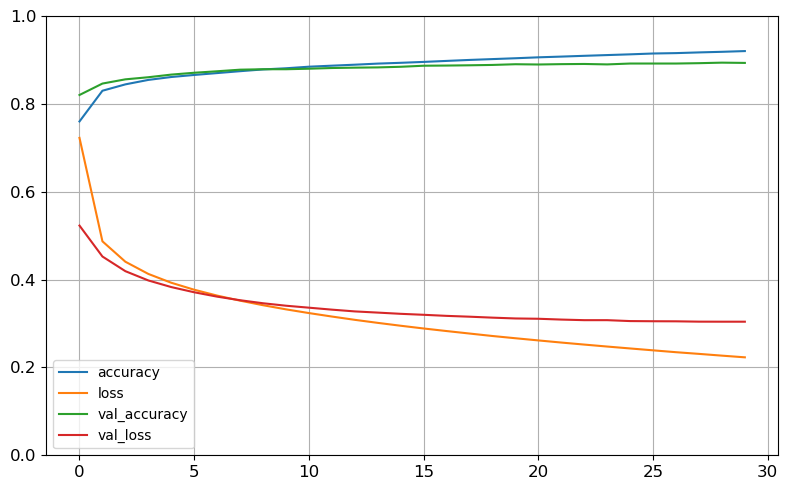

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8767 - loss: 0.3453


[0.34257972240448, 0.8769000172615051]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([9, 2, 1], dtype=int64)

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


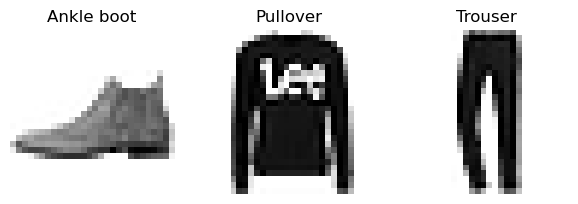

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset:

In [ ]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


c:\Users\chern\anaconda3\envs\ML_template\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.3647 - val_loss: 0.9462
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8455 - val_loss: 0.6985
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7522 - val_loss: 0.6626
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7072 - val_loss: 0.6189
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6713 - val_loss: 0.5885
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6420 - val_loss: 0.5630
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6180 - val_loss: 0.5439
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5978 - val_loss: 0.5313
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5803 - val_loss: 0.5183
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5641 - val_loss: 0.5073
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5501 - val_loss: 0.4970
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

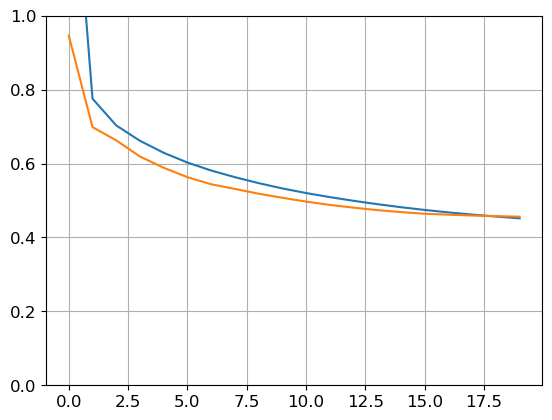

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred

array([[0.4976982],
       [1.5695257],
       [3.1555212]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30)        │        270 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 30)        │        930 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.0488 - val_loss: 1.0747
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8363 - val_loss: 0.6868
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7347 - val_loss: 0.6265
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6791 - val_loss: 0.5829
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6351 - val_loss: 0.5468
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5989 - val_loss: 0.5175
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5687 - val_loss: 0.4922
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5430 - val_loss: 0.4713
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5214 - val_loss: 0.4548
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5032 - val_loss: 0.4421
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4878 - val_loss: 0.4326
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.0591 - val_loss: 0.9698
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8795 - val_loss: 0.7642
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7615 - val_loss: 0.6745
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6997 - val_loss: 0.6191
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6522 - val_loss: 0.5770
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6147 - val_loss: 0.5432
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5842 - val_loss: 0.5152
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5586 - val_loss: 0.4925
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5375 - val_loss: 0.4761
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5204 - val_loss: 0.4655
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5067 - val_loss: 0.4564
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Adding an auxiliary output for regularization:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [ ]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - aux_output_loss: 5.0122 - loss: 4.2875 - main_output_loss: 4.2070 - val_aux_output_loss: 3.4824 - val_loss: 1.4468 - val_main_output_loss: 1.2204
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - aux_output_loss: 3.2287 - loss: 1.2250 - main_output_loss: 1.0024 - val_aux_output_loss: 2.7888 - val_loss: 0.9515 - val_main_output_loss: 0.7472
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - aux_output_loss: 2.2571 - loss: 0.9076 - main_output_loss: 0.7576 - val_aux_output_loss: 2.3873 - val_loss: 0.8075 - val_main_output_loss: 0.6317
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - aux_output_loss: 1.7945 - loss: 0.7879 - main_output_loss: 0.6761 - val_aux_output_loss: 2.0169 - val_loss: 0.7242 - val_main_output_loss: 0.5804
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - aux_output_loss: 1.5616 - loss: 0.7250 - main_output_loss: 0.6321 - val_aux_output_loss: 1.6887 - val_loss: 0.6609 - val_main_output_loss: 0.5465


In [ ]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - aux_output_loss: 0.8580 - loss: 0.4742 - main_output_loss: 0.4315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


# The subclassing API

In [ ]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 882us/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 646us/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 658us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 653us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 649us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 664us/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 677us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 649us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 676us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 497us/step - loss: 0.438

# Using Callbacks during Training

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 846us/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 672us/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 658us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 651us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 670us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 658us/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 682us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 657us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 672us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 460us/step - loss: 0.438

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 878us/step - loss: 0.4578 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 702us/step - loss: 0.4430 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 676us/step - loss: 0.4376 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 671us/step - loss: 0.4361 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 674us/step - loss: 0.4204 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 672us/step - loss: 0.4112 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 671us/step - loss: 0.4226 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 659us/step - loss: 0.4135 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 661us/step - loss: 0.4039 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 655us/step - l

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 799us/step - loss: 0.3302 - val_loss: 0.3556

val/train: 1.08


# TensorBoard

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_02_13-18_39_20'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 927us/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 695us/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 668us/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 672us/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 692us/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 755us/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 697us/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 668us/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 681us/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 701us/step - loss: 0.454

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2021_02_13-18_39_31'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.7645 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 0s 713us/step - loss: 8159520618.2209 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 735us/step - loss: 1.3439 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 738us/step - loss: 1.3546 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 712us/step - loss: 1.3513 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 0s 724us/step - loss: 1.3274 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 0s 693us/step - loss: 1.3639 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 0s 709us/step - loss: 1.3487 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 0s 681us/step - loss: 1.3445 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 0s 681us/step - lo

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [ ]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 0s 905us/step - loss: 1.5673 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 665us/step - loss: 1.3216 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 671us/step - loss: 0.5972 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 661us/step - loss: 0.4985 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 687us/step - loss: 0.4608 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 678us/step - loss: 0.4410 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 676us/step - loss: 0.4463 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 686us/step - loss: 0.4283 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 660us/step - loss: 0.4139 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 681us/step - 

In [ ]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 417us/step - loss: 0.3409


In [ ]:
y_pred = keras_reg.predict(X_new)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon. In the meantime, I've added `.tolist()` and `.rvs(1000).tolist()` as workarounds.

In [ ]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3827 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 757us/step - loss: 0.4880 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 765us/step - loss: 0.4541 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 745us/step - loss: 0.4518 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 765us/step - loss: 0.4337 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 751us/step - loss: 0.4263 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 743us/step - loss: 0.4385 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 780us/step - loss: 0.4301 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 792us/step - loss: 0.4108 - val_loss: 0.4040
Epoch 10/100
2

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd939643c10>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.0...
                                                          0.00502142573

In [ ]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [ ]:
rnd_search_cv.best_score_

-0.32039451599121094

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 436us/step - loss: 0.3029


-0.3028871417045593

In [ ]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 446us/step - loss: 0.3029


0.3028871417045593